In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import graphviz
%matplotlib inline

import os
os.environ["PATH"] += os.pathsep + 'D:/Program Files (x86)/Graphviz2.38/bin/'

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

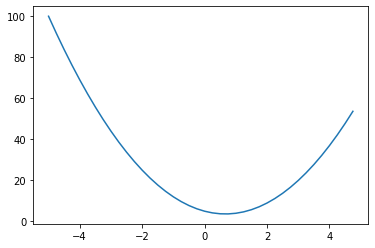

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [18]:
class Value:
    
    def __init__(self, data, _children=(), _op="", label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        
        return out
        
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self * other**-1

    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)
    
    def __rsub__(self, other):
        return self - other
    
    def __radd__(self, other): # other + self
        return self + other
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1-t**2) * out.grad
        out._backward = _backward
        
        
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        
        def backward():
            self.grad = out.data * out.grad
        out._backward = _backward()
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label='e'
d = e + c; d.label = "d"
f = Value(-2.0, label='f')
L = d * f; L.label = "L"
L

value(data=-8.0)

In [7]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

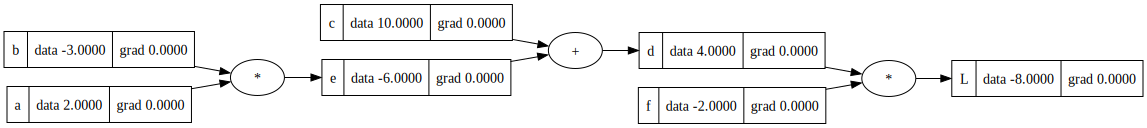

In [8]:
draw_dot(L)

In [9]:
L = d * f


In [10]:
L.grad = 1.0

In [11]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

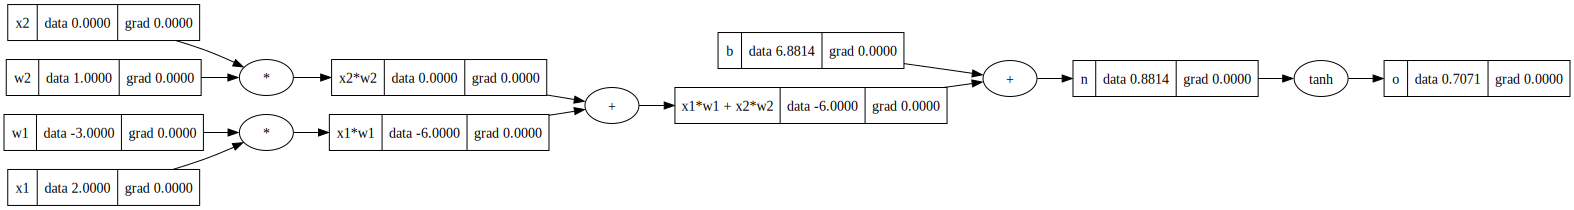

In [12]:
draw_dot(o)

In [13]:
o.backward()

In [59]:
import random
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    
    def __call__(self, x):
        # w * x + b
        
        act = sum( (wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
#         return [p for layer in self.layers for p in layers.parameters()]
    
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
len(n.parameters())



41

In [60]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

ypred = [M(x) for x in xs]

In [62]:
alpha = .01

for _ in range(1000):
    
    # zero grad
    for p in n.parameters():
        p.grad = 0.0
    
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum([(ygt - yout)**2 for ygt, yout in zip(ys, ypred)])
    print(f'loss = {loss}')
    
    # backward pass/update
    loss.backward()
    for p in n.parameters():
        p.data += -alpha*p.grad

loss = sum([(ygt - yout)**2 for ygt, yout in zip(ys, ypred)])
print(f'final loss = {loss}')
print(f'ypred={ypred}')

loss = value(data=0.06923849321235286)
loss = value(data=0.0680799347471094)
loss = value(data=0.06695550633852586)
loss = value(data=0.06586380006221162)
loss = value(data=0.0648034817267868)
loss = value(data=0.06377328623399418)
loss = value(data=0.06277201327748484)
loss = value(data=0.061798523352300065)
loss = value(data=0.06085173404964588)
loss = value(data=0.0599306166138593)
loss = value(data=0.059034192740550134)
loss = value(data=0.058161531596773314)
loss = value(data=0.0573117470457791)
loss = value(data=0.056483995060413045)
loss = value(data=0.05567747131062242)
loss = value(data=0.054891408911770564)
loss = value(data=0.05412507632159392)
loss = value(data=0.0533777753746624)
loss = value(data=0.05264883944413257)
loss = value(data=0.05193763172143119)
loss = value(data=0.05124354360527171)
loss = value(data=0.050565993192106334)
loss = value(data=0.04990442386075554)
loss = value(data=0.04925830294453144)
loss = value(data=0.04862712048470546)
loss = value(data=0.0480

loss = value(data=0.012916602452246177)
loss = value(data=0.012862062189843586)
loss = value(data=0.012807948648926173)
loss = value(data=0.012754256993036128)
loss = value(data=0.012700982457224725)
loss = value(data=0.012648120346751848)
loss = value(data=0.012595666035813125)
loss = value(data=0.012543614966294699)
loss = value(data=0.012491962646554508)
loss = value(data=0.012440704650229627)
loss = value(data=0.012389836615068876)
loss = value(data=0.012339354241790322)
loss = value(data=0.012289253292962725)
loss = value(data=0.012239529591910714)
loss = value(data=0.012190179021642739)
loss = value(data=0.01214119752380174)
loss = value(data=0.012092581097637166)
loss = value(data=0.01204432579899892)
loss = value(data=0.011996427739351844)
loss = value(data=0.011948883084810501)
loss = value(data=0.011901688055193935)
loss = value(data=0.011854838923099707)
loss = value(data=0.011808332012997084)
loss = value(data=0.011762163700338245)
loss = value(data=0.01171633041068815)
los

loss = value(data=0.006050772604600343)
loss = value(data=0.006037537620056009)
loss = value(data=0.006024356940907317)
loss = value(data=0.006011230242178934)
loss = value(data=0.005998157201445382)
loss = value(data=0.005985137498806246)
loss = value(data=0.00597217081686182)
loss = value(data=0.0059592568406888445)
loss = value(data=0.005946395257816745)
loss = value(data=0.0059335857582039735)
loss = value(data=0.005920828034214679)
loss = value(data=0.005908121780595722)
loss = value(data=0.00589546669445371)
loss = value(data=0.005882862475232637)
loss = value(data=0.005870308824691436)
loss = value(data=0.005857805446882181)
loss = value(data=0.005845352048127952)
loss = value(data=0.005832948337001693)
loss = value(data=0.005820594024304599)
loss = value(data=0.005808288823045215)
loss = value(data=0.005796032448418666)
loss = value(data=0.005783824617785914)
loss = value(data=0.005771665050653507)
loss = value(data=0.005759553468653485)
loss = value(data=0.00574748959552342)
l

loss = value(data=0.0038872394788112335)
loss = value(data=0.0038814871224465393)
loss = value(data=0.00387575083072343)
loss = value(data=0.0038700305380228363)
loss = value(data=0.003864326179077901)
loss = value(data=0.003858637688971569)
loss = value(data=0.003852965003134186)
loss = value(data=0.0038473080573413077)
loss = value(data=0.0038416667877114053)
loss = value(data=0.0038360411307035098)
loss = value(data=0.0038304310231151205)
loss = value(data=0.0038248364020797444)
loss = value(data=0.0038192572050649823)
loss = value(data=0.00381369336987006)
loss = value(data=0.003808144834623768)
loss = value(data=0.003802611537782352)
loss = value(data=0.003797093418127291)
loss = value(data=0.003791590414763176)
loss = value(data=0.0037861024671156274)
loss = value(data=0.003780629514929179)
loss = value(data=0.003775171498265218)
loss = value(data=0.0037697283574999255)
loss = value(data=0.0037643000333221904)
loss = value(data=0.003758886466731629)
loss = value(data=0.0037534875

loss = value(data=0.0028193247799219363)
loss = value(data=0.0028161922493899648)
loss = value(data=0.002813066314226509)
loss = value(data=0.002809946954084703)
loss = value(data=0.0028068341487002373)
loss = value(data=0.002803727877890956)
loss = value(data=0.0028006281215564414)
loss = value(data=0.0027975348596775305)
loss = value(data=0.0027944480723161233)
loss = value(data=0.002791367739614478)
loss = value(data=0.0027882938417950753)
loss = value(data=0.0027852263591600555)
loss = value(data=0.002782165272090854)
loss = value(data=0.002779110561047865)
loss = value(data=0.0027760622065699644)
loss = value(data=0.0027730201892742067)
loss = value(data=0.0027699844898553426)
loss = value(data=0.0027669550890854996)
loss = value(data=0.0027639319678137856)
loss = value(data=0.0027609151069658937)
loss = value(data=0.002757904487543721)
loss = value(data=0.0027549000906250186)
loss = value(data=0.0027519018973629988)
loss = value(data=0.0027489098889859048)
loss = value(data=0.002